In [1]:
import os
import pandas as pd
from calendar import month_abbr
from collections import defaultdict

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None) 

In [2]:
# Identify file names
raw_names = [name for name in os.listdir("Data/") if not name.startswith('.')]

# Split file names
split_names = [name.split("_") for name in raw_names]

# Manipulate to format "MONDD"
better_names = [month_abbr[int(split_name[1])] + split_name[2] for split_name in split_names]

In [3]:
# Initialize dictionary to hold DataFrames
raw_activities = defaultdict(list)

# Read in data and add to dictionary with better_names as keys
for raw_name, better_name in zip(raw_names, better_names):
    raw_activities[better_name].append(pd.read_csv("Data/" + raw_name, skiprows=9))

# Create a new dictionary for modified keys
activities = {}
# Check for duplicates and append numerical suffix
for name, dfs in raw_activities.items():
    if len(dfs) > 1:
        for i, df in enumerate(dfs):
            activities[f"{name} ({i+1})"] = df
    else:
        activities[name] = dfs[0]

Check if columns aren't the same in any dataframes (there are none)

In [4]:
# Initialize a set to store unique column names across all DataFrames
all_columns = set()

# Iterate over each DataFrame in the activities dictionary
for df in activities.values():
    # Update the set of column names with the current DataFrame's columns
    all_columns.update(df.columns)

# Initialize a dictionary to store missing columns for each DataFrame
missing_columns = {}

# Iterate over each DataFrame in the activities dictionary again
for name, df in activities.items():
    # Calculate the difference between all columns and the DataFrame's columns
    missing_cols = all_columns - set(df.columns)
    # Print if there are missing columns
    if missing_cols:
        print(f"Missing columns in DataFrame '{name}': {missing_cols}")

Remove Missing Value Columns

In [5]:
# Initialize a dictionary to store counts of missing columns across dataframes
missing_column_counts = {}

# Iterate over each DataFrame in the activities dictionary
for df in activities.values():
    # Iterate over each column in the DataFrame
    for col in df.columns:
        # If the column is not in the missing_column_counts dictionary, initialize its count to 0
        if col not in missing_column_counts:
            missing_column_counts[col] = 0
        # Check if all values in the column are missing (NaN)
        if df[col].isna().all():
            # If all values are missing, increment the count for this column
            missing_column_counts[col] += 1

# Convert the missing_column_counts dictionary to a DataFrame
missing_column_counts_df = pd.DataFrame(list(missing_column_counts.items()), columns=['Column Name', 'Missing DF Count'])

drop_cols = missing_column_counts_df[missing_column_counts_df["Missing DF Count"] > 0].sort_values(by="Missing DF Count")

drop_cols

,Column Name,Missing DF Count
298,RHIE Efforts Per Bout - Min,12
1150,Athlete Participation Tags,113
1147,Athlete Tags,146
3,MII Distance Interval 1 Start Time,147
961,Velocity B8 Minimum Effort Distance (Gen 2),147
...,...,...
90,Velocity Band 4 Min Effort Duration,147
89,Velocity Band 3 Min Effort Duration,147
88,Velocity Band 2 Min Effort Duration,147
1151,Period Tags,147


In [6]:
for df in activities.values():
    # Fill missing values in the column "RHIE Efforts Per Bout - Min" with 0
    df["RHIE Efforts Per Bout - Min"].fillna(0, inplace=True)

drop_cols = drop_cols.drop(drop_cols.index[0])

In [7]:
for df in activities.values():
    # Drop columns based on the values in the "Column Name" column of drop_cols DataFrame
    df.drop(columns=drop_cols["Column Name"], inplace=True, errors='ignore')

Get Games Data

In [8]:
game_names = ["Nov06", "Nov10", "Nov15", "Nov18", "Nov23", "Nov24",
         "Dec01", "Dec05", "Dec09", "Dec13", "Dec16", "Dec22", "Dec30",
         "Jan06", "Jan09", "Jan13", "Jan16", "Jan20", "Jan23", "Jan27",
         "Feb03", "Feb06", "Feb10", "Feb13", "Feb17", "Feb20", "Feb24", "Feb27",
         "Mar02", "Mar06", "Mar09", "Mar13", "Mar14", "Mar21"]

In [9]:
# Initialize an empty dictionary to store game DataFrames
games = {}

# Iterate over each game name in game_names
for game_name in game_names:
    # Check if the game name exists in the activities dictionary
    if game_name in activities:
        # If it exists, add the DataFrame to the games dictionary
        games[game_name] = activities[game_name]

Get Kenpom Data

In [10]:
# Did this in R because there is no python package that allows importing kenpom data well
kp = pd.read_csv("kp_game_data.csv")

In [11]:
kp_join = kp[["date", "player", "o_rtg"]]

In [12]:
kp_join[kp_join["o_rtg"] == 220]

,date,player,o_rtg
266,Feb20,Aly Khalifa,220.0


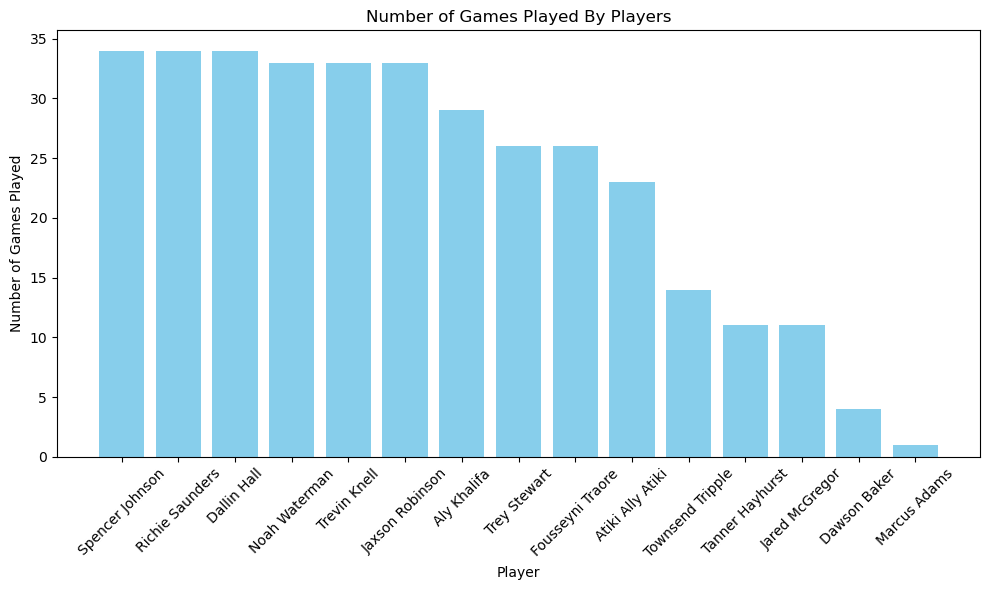

In [13]:
import matplotlib.pyplot as plt
player_counts = kp_join["player"].value_counts()

players = list(player_counts.index)
counts = list(player_counts.values)

plt.figure(figsize=(10, 6))
plt.bar(players, counts, color='skyblue')
plt.xlabel('Player')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played By Players')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [14]:
# Get the list of players that appear more than 20 times
players_to_keep = player_counts[player_counts > 20].index.tolist()

In [15]:
# Filter the DataFrame to keep only the rows where the player appears more than 20 times
kp_join = kp_join[kp_join["player"].isin(players_to_keep)]

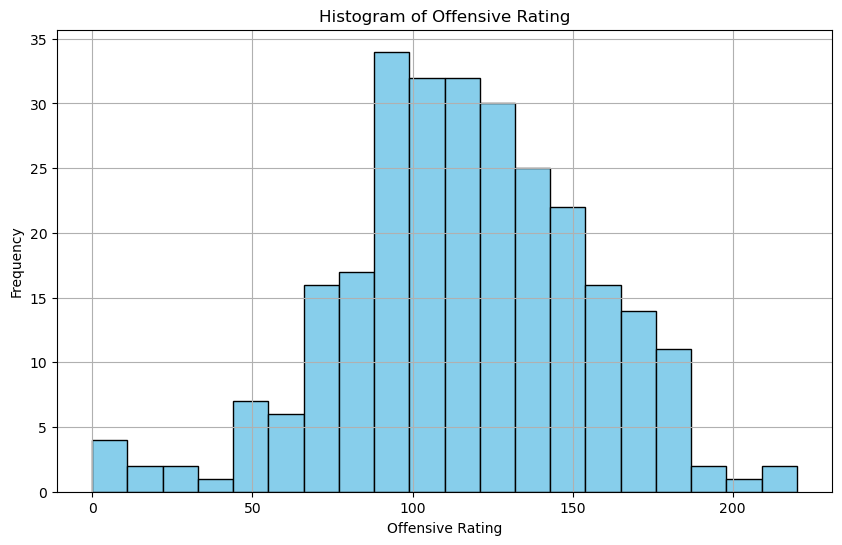

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(kp_join["o_rtg"], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Offensive Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Offensive Rating')
plt.grid(True)
plt.show()

In [17]:
kp_join["o_rtg"].describe()

count    276.000000
mean     115.789855
std       38.369866
min        0.000000
25%       93.000000
50%      116.500000
75%      142.000000
max      220.000000
Name: o_rtg, dtype: float64

Feature Engenieer Catapult Data

In [18]:
dfs = []
for name, df in games.items():
    df['game_date'] = name
    dfs.append(df)
gamedf = pd.concat(dfs, ignore_index=True)

gamedf = gamedf[gamedf["Period Name"] == "Session"]

In [19]:
gamedf["Player Name"] = gamedf["Player Name"].replace('Atiki Atiki', 'Atiki Ally Atiki')
gamedf["Player Name"] = gamedf["Player Name"].replace('Fouss Traore', 'Fousseyni Traore')

gamedf = gamedf[gamedf["Player Name"].isin(players_to_keep)]

gamedf["Player Name"].value_counts()

Dallin Hall         34
Spencer Johnson     34
Richie Saunders     34
Trevin Knell        33
Trey Stewart        33
Noah Waterman       33
Atiki Ally Atiki    32
Jaxson Robinson     32
Aly Khalifa         29
Fousseyni Traore    27
Name: Player Name, dtype: int64

In [20]:
# drop all columns where the values are 0
gamedf = gamedf.drop(columns=gamedf.columns[(df.eq(0).all() | df.eq('00:00:00').all())])

In [21]:
# drop columns that are irrelevant
# add back maybe "Activity Tags", "Position Name"
gamedf = gamedf.drop(columns=["Period Name", "Period Number", "Unix Start Time", "Unix End Time", "HR 0-30% Mins", "Heart Rate Band 1 Duration %",
                       "Session Count", "Jersey", "Profile Max Heart Rate", "Profile Max Velocity", "Activity Name", "Average Player Load",
                       "Player Load (avg)", "Average Duration", "Duration (avg)", "Duration", "Field Time", "Heart Rate Band 1 Average Duration",
                        "HR 0-30% Mins (avg)", "Movement Load (avg)", "Movement Load (time)", "Team Name", "Total Activities", 
                        "Average Estimated Distance (Session)", "Average Jump Count Low (Session)", "Average Jump Count Medium (Session)", 
                        "Average Jump Count High (Session)", "Average Jump Count (Session)", "Activity Tags", "Position Name"])

In [22]:
# Covnert time variabels to minute decimals
import re
for col in gamedf.columns:
    # Check if column values follow the format ##:##:##
    if all(re.match(r'\d{2}:\d{2}:\d{2}', str(val)) for val in gamedf[col]):
        # Convert values to timedelta
        gamedf[col] = pd.to_timedelta(gamedf[col])
        # Convert timedelta to minutes and then to decimal
        gamedf[col] = gamedf[col].dt.total_seconds() / 60

/var/folders/g7/gnzs3l6x61xcl7ny9d10xjjm0000gn/T/ipykernel_98182/3097428728.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = gamedf.corr()


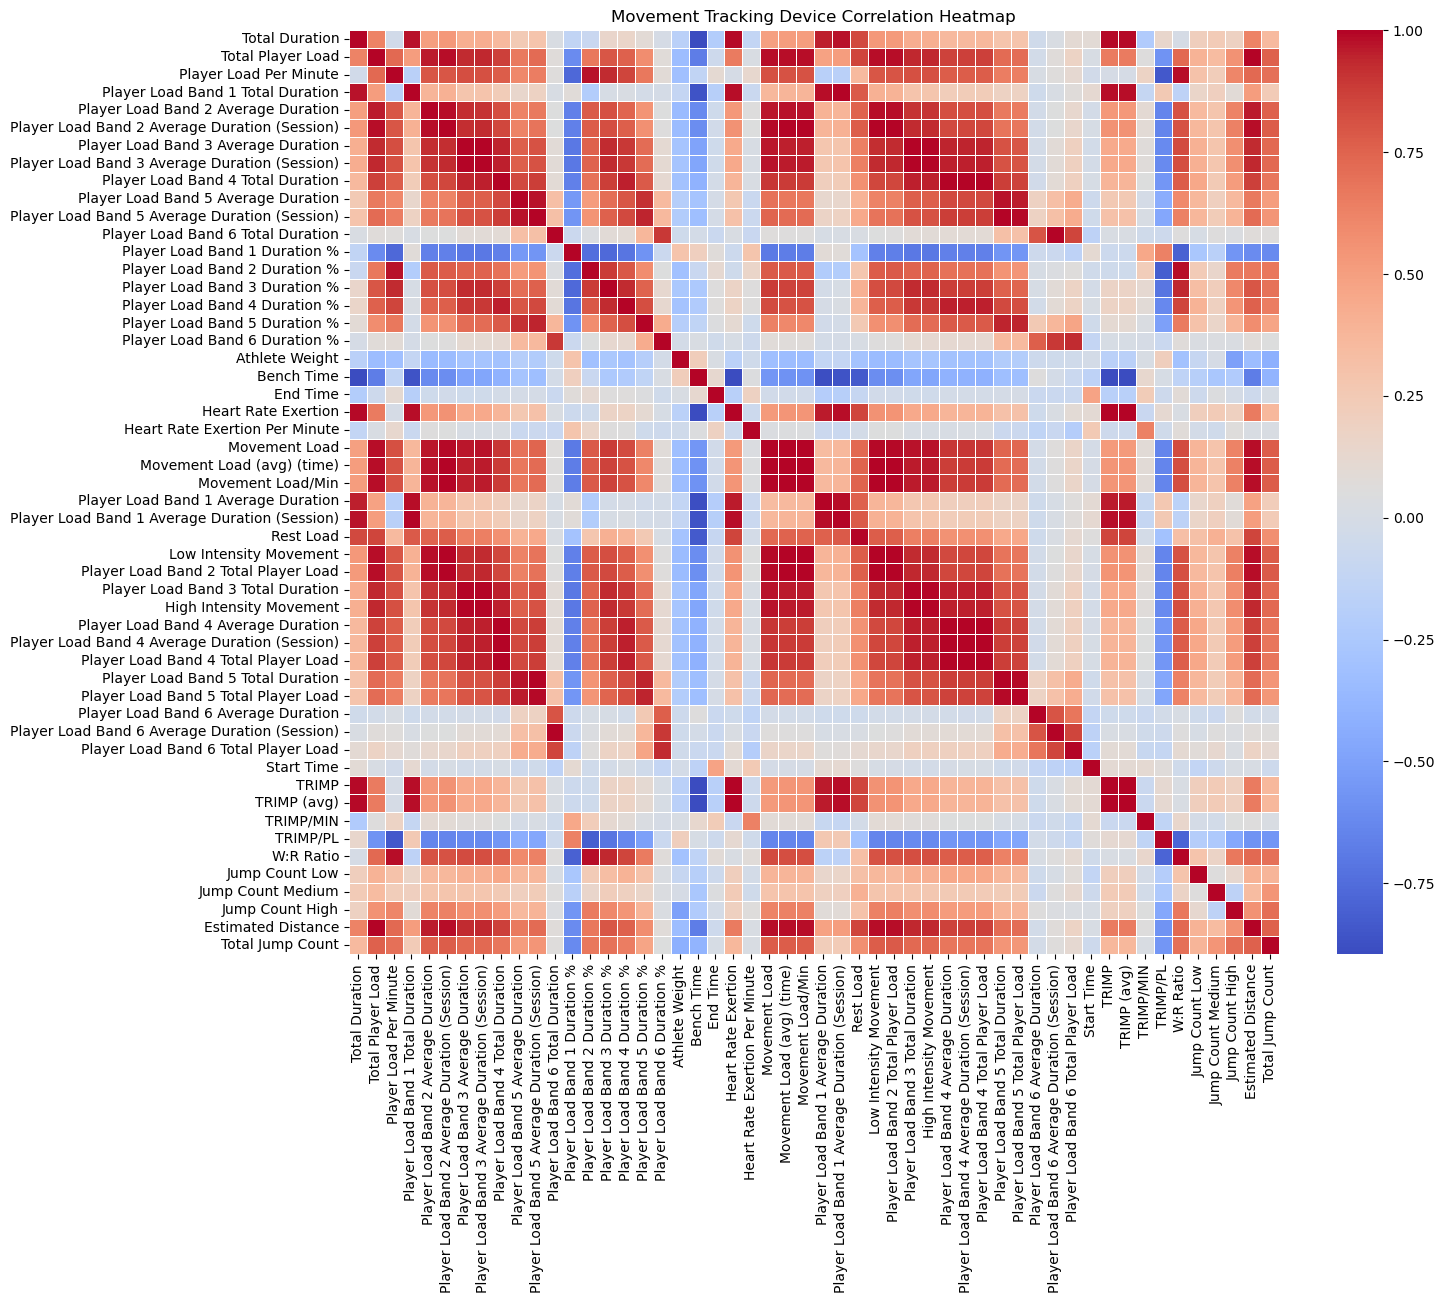

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'kp_join'
# If not, replace 'kp_join' with the name of your DataFrame
correlation_matrix = gamedf.corr()

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Movement Tracking Device Correlation Heatmap')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Rotate y-axis labels for better readability
plt.show()


Joining df's

In [24]:
data = pd.merge(kp_join, gamedf, left_on=['player', 'date'], right_on=['Player Name', 'game_date'])

In [25]:
data = data[data["o_rtg"] > 0]

In [26]:
data = data.reset_index(drop=True)

In [27]:
data = data.drop(columns=["date", "player", "game_date"])

# Setting Up Data For Machine Learning

In [28]:
data = pd.concat([data, pd.get_dummies(data['Player Name'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['Day Name'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['Month Name'])], axis=1)
data = data.drop(columns=["Player Name", "Day Name", "Month Name"])

data['Date'] = pd.to_datetime(data['Date'])
min_date = data['Date'].min()
data['Date'] = (data['Date'] - min_date).dt.days + 1

In [29]:
data.dtypes.value_counts()

float64    41
uint8      21
int64      13
dtype: int64

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

X = data.drop(columns=["o_rtg"])
y = data["o_rtg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=316)

# Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, lr_pred, squared=False)}")

RMSE: 34.7464126345824


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, nb_pred, squared=False)}")

RMSE: 39.523985812990254


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=316)

rf_grid = { # these values were tuned to reduce rmse
    'n_estimators': list(range(25, 36)), 
    'max_depth': [1, 2, 3],
    'min_samples_split': [2,3,4,5,6,7,8]}

rf_grid_search = GridSearchCV(rf_model, rf_grid, cv=10, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

rf_best_model = rf_grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)

rf_pred = rf_best_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, rf_pred, squared=False)}")

pd.DataFrame(rf_grid_search.cv_results_).sort_values(by="rank_test_score").head(10)

Fitting 10 folds for each of 231 candidates, totalling 2310 fits
RMSE: 32.963540271203044


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
112,0.041342,0.008582,0.002495,0.001508,2,5,27,"{'max_depth': 2, 'min_samples_split': 5, 'n_es...",-37.891577,-34.302981,-38.294007,-31.342465,-47.552856,-35.187680,-45.135987,-27.551053,-41.918147,-25.043012,-36.421976,6.897041,1
101,0.039152,0.007807,0.002286,0.001239,2,4,27,"{'max_depth': 2, 'min_samples_split': 4, 'n_es...",-37.887778,-34.606512,-38.294007,-31.406328,-47.552856,-35.187680,-45.134947,-27.551053,-41.915289,-25.043012,-36.457946,6.883162,2
90,0.042755,0.006624,0.002845,0.001640,2,3,27,"{'max_depth': 2, 'min_samples_split': 3, 'n_es...",-37.887778,-34.707146,-38.226196,-31.406328,-47.552856,-35.187680,-45.134947,-27.551053,-41.896529,-25.043012,-36.459352,6.877266,3
79,0.038245,0.004953,0.002290,0.001164,2,2,27,"{'max_depth': 2, 'min_samples_split': 2, 'n_es...",-37.887778,-34.707146,-38.226196,-31.406328,-47.552856,-35.155801,-45.134947,-27.551053,-41.896529,-25.085087,-36.460372,6.870888,4
145,0.037813,0.005036,0.002575,0.001228,2,8,27,"{'max_depth': 2, 'min_samples_split': 8, 'n_es...",-37.775793,-34.878360,-38.294007,-31.415615,-47.552856,-35.227055,-45.308914,-27.507701,-41.646368,-25.071390,-36.467806,6.875021,5
134,0.040265,0.005686,0.002429,0.001346,2,7,27,"{'max_depth': 2, 'min_samples_split': 7, 'n_es...",-37.891577,-34.885443,-38.294007,-31.415615,-47.552856,-35.173031,-45.135987,-27.507701,-41.840352,-25.071390,-36.476796,6.871011,6
119,0.049387,0.006178,0.001940,0.001189,2,5,34,"{'max_depth': 2, 'min_samples_split': 5, 'n_es...",-37.486476,-34.546414,-38.657747,-32.217658,-47.951141,-35.104041,-44.748864,-27.374208,-41.391304,-25.356718,-36.483457,6.784394,7
123,0.039491,0.003062,0.002372,0.001335,2,6,27,"{'max_depth': 2, 'min_samples_split': 6, 'n_es...",-37.891577,-34.885443,-38.294007,-31.415615,-47.552856,-35.203691,-45.135987,-27.551053,-41.918147,-25.043012,-36.489139,6.875612,8
114,0.043659,0.014956,0.002795,0.001574,2,5,29,"{'max_depth': 2, 'min_samples_split': 5, 'n_es...",-37.968656,-34.147275,-38.879237,-31.585057,-47.743225,-35.105982,-45.000060,-27.497025,-41.664497,-25.332124,-36.492314,6.859742,9
141,0.047097,0.007759,0.002102,0.001358,2,7,34,"{'max_depth': 2, 'min_samples_split': 7, 'n_es...",-37.556100,-35.012021,-38.656620,-32.270147,-47.900288,-35.134848,-44.656972,-27.321935,-41.326101,-25.379841,-36.521487,6.748481,10


# Gradient Boosting

In [34]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=316)

xgb_grid = { # these were tuned down to these values for speed of running whole notebook
    'n_estimators': list(range(100, 111)),  
    'max_depth': list(range(3, 10)), 
    'min_child_weight': [1],  
    'eta': [0.01], 
    'max_leaves': [5]  
}

xgb_grid_search = GridSearchCV(xgb_model, xgb_grid, cv=10, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

xgb_best_model = xgb_grid_search.best_estimator_
xgb_best_model.fit(X_train, y_train)

xgb_pred = xgb_best_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, xgb_pred, squared=False)}")

pd.DataFrame(xgb_grid_search.cv_results_).sort_values(by="rank_test_score").head(10)

Fitting 10 folds for each of 77 candidates, totalling 770 fits
RMSE: 32.93228965401218


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_max_leaves,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
38,0.107050,0.029126,0.002247,0.001181,0.01,6,5,1,105,"{'eta': 0.01, 'max_depth': 6, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
71,0.119261,0.041808,0.002066,0.000974,0.01,9,5,1,105,"{'eta': 0.01, 'max_depth': 9, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
60,0.104826,0.012185,0.002261,0.001158,0.01,8,5,1,105,"{'eta': 0.01, 'max_depth': 8, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
5,0.091625,0.010375,0.001485,0.000544,0.01,3,5,1,105,"{'eta': 0.01, 'max_depth': 3, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
49,0.108498,0.008224,0.003270,0.001929,0.01,7,5,1,105,"{'eta': 0.01, 'max_depth': 7, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
27,0.113837,0.012617,0.002408,0.001874,0.01,5,5,1,105,"{'eta': 0.01, 'max_depth': 5, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
16,0.098137,0.009078,0.001519,0.000326,0.01,4,5,1,105,"{'eta': 0.01, 'max_depth': 4, 'max_leaves': 5,...",-36.846388,-32.492781,-36.600253,-31.034391,-47.856599,-36.119979,-44.821249,-27.864748,-41.661320,-24.110208,-35.940791,7.042778,1
65,0.105945,0.010720,0.001835,0.000910,0.01,8,5,1,110,"{'eta': 0.01, 'max_depth': 8, 'max_leaves': 5,...",-36.803040,-32.642489,-36.577538,-31.061209,-47.804368,-36.099637,-44.778828,-27.918582,-41.634815,-24.113629,-35.943413,7.009836,8
54,0.104057,0.015961,0.001781,0.000783,0.01,7,5,1,110,"{'eta': 0.01, 'max_depth': 7, 'max_leaves': 5,...",-36.803040,-32.642489,-36.577538,-31.061209,-47.804368,-36.099637,-44.778828,-27.918582,-41.634815,-24.113629,-35.943413,7.009836,8
43,0.106149,0.012518,0.002453,0.001897,0.01,6,5,1,110,"{'eta': 0.01, 'max_depth': 6, 'max_leaves': 5,...",-36.803040,-32.642489,-36.577538,-31.061209,-47.804368,-36.099637,-44.778828,-27.918582,-41.634815,-24.113629,-35.943413,7.009836,8


# K-nearest neighbors

In [35]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

knn_grid = { # these values were tuned to reduce rmse
    'n_neighbors': list(range(1, 120)), 
    'weights': ['uniform'],
    'algorithm': ['ball_tree', 'kd_tree']
}

knn_grid_search = GridSearchCV(knn_model, knn_grid, cv=10, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

knn_best_model = knn_grid_search.best_estimator_
knn_best_model.fit(X_train, y_train)

knn_pred = knn_best_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, knn_pred, squared=False)}")

pd.DataFrame(knn_grid_search.cv_results_).sort_values(by="rank_test_score").head(10)

Fitting 10 folds for each of 238 candidates, totalling 2380 fits
RMSE: 32.45437347965466


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
167,0.002230,0.001161,0.002505,0.001205,kd_tree,49,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 49, 'w...",-39.116000,-30.041038,-39.669979,-30.693987,-47.398638,-38.378117,-44.447401,-29.249776,-42.532404,-25.340128,-36.686747,7.006701,1
48,0.001518,0.001147,0.001467,0.000629,ball_tree,49,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 49, ...",-39.116000,-30.041038,-39.669979,-30.693987,-47.398638,-38.378117,-44.447401,-29.249776,-42.532404,-25.340128,-36.686747,7.006701,1
97,0.001464,0.000956,0.001858,0.001389,ball_tree,98,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 98, ...",-39.541378,-30.957088,-39.200248,-30.137885,-47.656326,-38.339995,-43.644804,-28.729286,-42.456785,-26.356919,-36.702071,6.818945,3
216,0.001505,0.000686,0.001896,0.000933,kd_tree,98,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 98, 'w...",-39.541378,-30.957088,-39.200248,-30.137885,-47.656326,-38.339995,-43.644804,-28.729286,-42.456785,-26.356919,-36.702071,6.818945,3
217,0.001323,0.000527,0.001859,0.000704,kd_tree,99,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 99, 'w...",-39.606670,-30.777667,-39.177385,-30.143941,-47.546035,-38.289749,-43.798668,-28.879891,-42.488105,-26.357158,-36.706527,6.817824,5
98,0.001120,0.000493,0.002141,0.002114,ball_tree,99,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 99, ...",-39.606670,-30.777667,-39.177385,-30.143941,-47.546035,-38.289749,-43.798668,-28.879891,-42.488105,-26.357158,-36.706527,6.817824,5
220,0.002741,0.002496,0.002702,0.000969,kd_tree,102,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 102, '...",-39.910620,-30.852299,-38.965606,-30.171129,-47.398743,-38.096774,-43.945130,-28.890068,-42.609073,-26.303545,-36.714299,6.820302,7
101,0.001155,0.000946,0.001507,0.000848,ball_tree,102,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 102,...",-39.910620,-30.852299,-38.965606,-30.171129,-47.398743,-38.096774,-43.945130,-28.890068,-42.609073,-26.303545,-36.714299,6.820302,7
221,0.001060,0.000339,0.001266,0.000128,kd_tree,103,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 103, '...",-40.076496,-30.840422,-39.004335,-30.222747,-47.383570,-38.066856,-44.020778,-28.837825,-42.492439,-26.217480,-36.716295,6.839939,9
102,0.000998,0.000499,0.001229,0.000222,ball_tree,103,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 103,...",-40.076496,-30.840422,-39.004335,-30.222747,-47.383570,-38.066856,-44.020778,-28.837825,-42.492439,-26.217480,-36.716295,6.839939,9


# Support Vector Machines

In [36]:
from sklearn.svm import SVR
import numpy as np

svm_model = SVR()

svm_grid = { 
    'kernel': ['rbf'], # Different types of kernels
    'C': np.arange(0.1, 2.1, 0.1).tolist(),            # Penalty parameter C
    'gamma': ['scale']    # Kernel coefficient
}

svm_grid_search = GridSearchCV(svm_model, svm_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

svm_best_model = svm_grid_search.best_estimator_
svm_best_model.fit(X_train, y_train)

svm_pred = svm_best_model.predict(X_test)

print(f"RMSE: {mean_squared_error(y_test, svm_pred, squared=False)}")

pd.DataFrame(svm_grid_search.cv_results_).sort_values(by="rank_test_score").head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RMSE: 34.076455668765355


/Users/carson/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.003400,0.001068,0.001656,0.000062,0.6,scale,rbf,"{'C': 0.6, 'gamma': 'scale', 'kernel': 'rbf'}",-36.387629,-35.356189,-41.864304,-38.317414,-35.184085,-37.421924,2.485220,1
4,0.003706,0.001503,0.002302,0.000813,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",-36.377166,-35.362385,-41.870922,-38.311361,-35.192342,-37.422835,2.485515,2
3,0.003395,0.001262,0.001854,0.000547,0.4,scale,rbf,"{'C': 0.4, 'gamma': 'scale', 'kernel': 'rbf'}",-36.384219,-35.368720,-41.877627,-38.308874,-35.200674,-37.428023,2.484601,3
6,0.002660,0.000272,0.002222,0.001295,0.7,scale,rbf,"{'C': 0.7000000000000001, 'gamma': 'scale', 'k...",-36.407215,-35.350425,-41.857774,-38.360083,-35.176625,-37.430424,2.486711,4
2,0.003962,0.001341,0.001652,0.000080,0.3,scale,rbf,"{'C': 0.30000000000000004, 'gamma': 'scale', '...",-36.391426,-35.374049,-41.884421,-38.306705,-35.208131,-37.432947,2.484057,5
7,0.002497,0.000155,0.002097,0.001210,0.8,scale,rbf,"{'C': 0.8, 'gamma': 'scale', 'kernel': 'rbf'}",-36.427071,-35.349218,-41.851331,-38.386608,-35.169433,-37.436732,2.486312,6
1,0.002681,0.000307,0.001722,0.000329,0.2,scale,rbf,"{'C': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}",-36.398787,-35.378044,-41.891302,-38.304479,-35.213848,-37.437292,2.484066,7
0,0.002780,0.000574,0.001610,0.000131,0.1,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",-36.406184,-35.382112,-41.898271,-38.279293,-35.224259,-37.438024,2.481684,8
8,0.003650,0.001186,0.002342,0.001273,0.9,scale,rbf,"{'C': 0.9, 'gamma': 'scale', 'kernel': 'rbf'}",-36.447195,-35.346894,-41.844977,-38.474355,-35.162322,-37.455149,2.491069,9
9,0.003482,0.000675,0.002338,0.000934,1.0,scale,rbf,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}",-36.467586,-35.342204,-41.838946,-38.525864,-35.154797,-37.465880,2.493791,10


# Feature Importance

In [37]:
feature_importance = pd.Series(rf_best_model.feature_importances_, index=X_train.columns)
sorted_features = feature_importance.sort_values(ascending=False)
sorted_features.head(10)

Jump Count High                        0.087442
Rest Load                              0.081956
Date                                   0.079267
Heart Rate Exertion Per Minute         0.075668
Player Load Band 1 Average Duration    0.069104
TRIMP/MIN                              0.061340
Player Load Band 5 Duration %          0.060359
Player Load Band 2 Duration %          0.056785
Player Load Band 3 Duration %          0.047857
End Time                               0.045323
dtype: float64

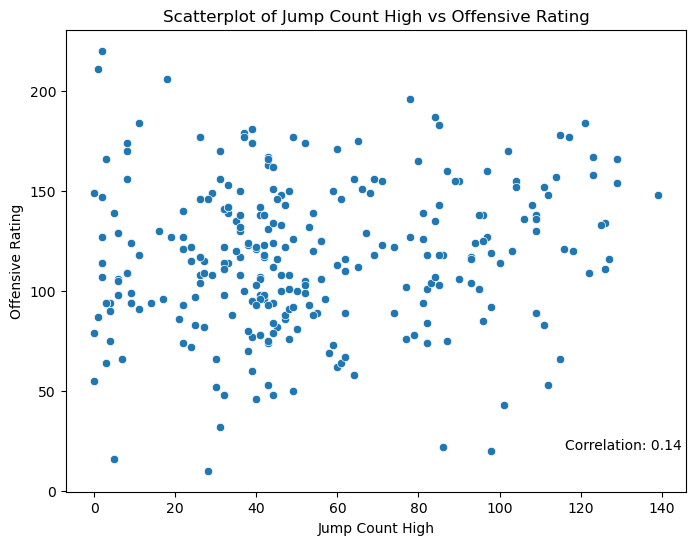

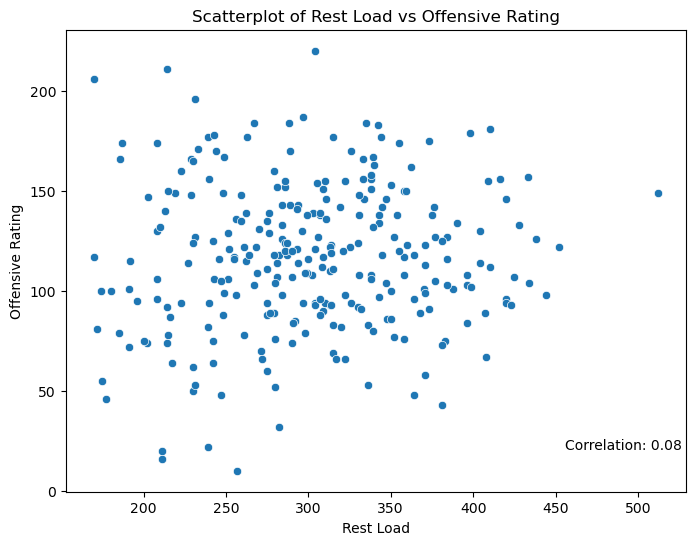

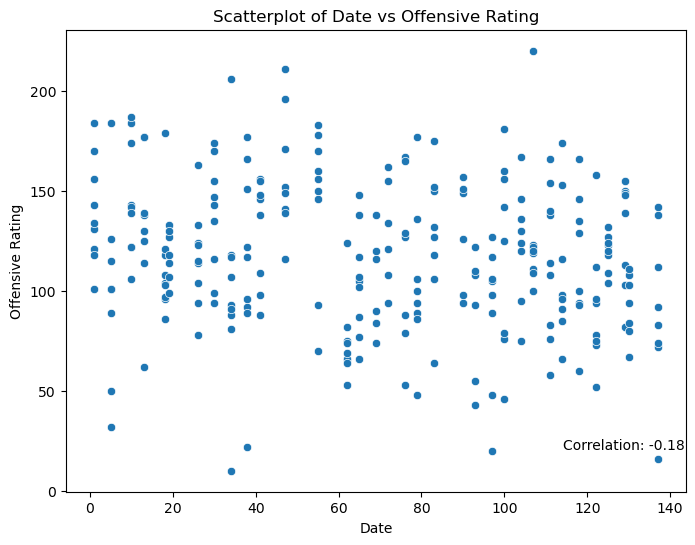

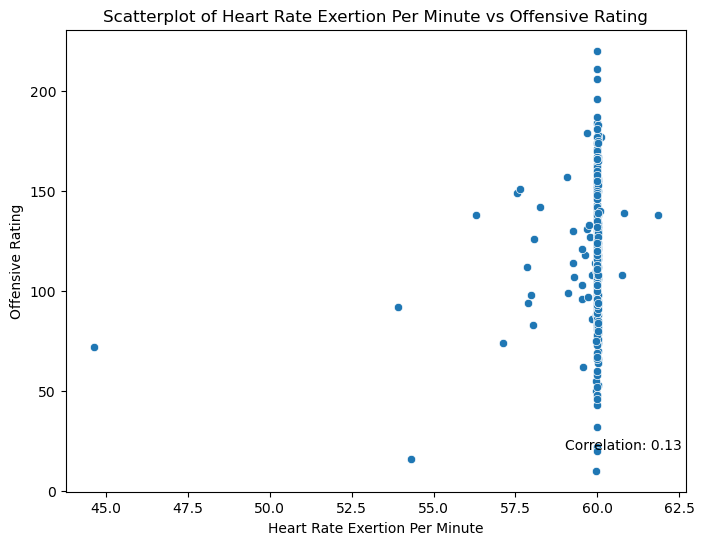

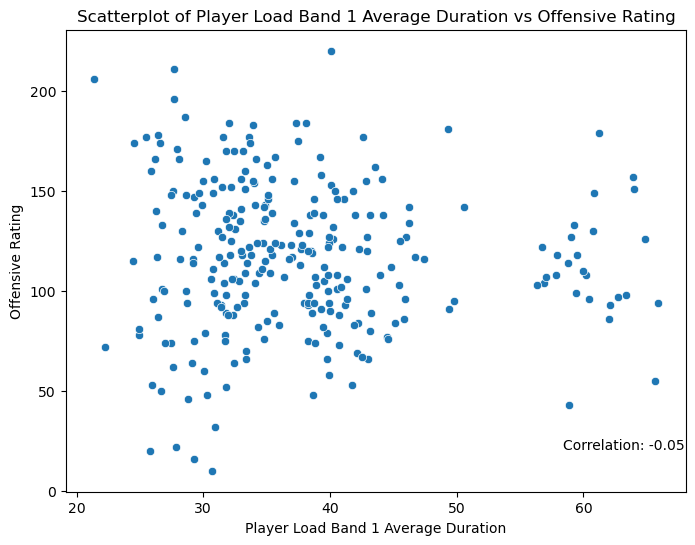

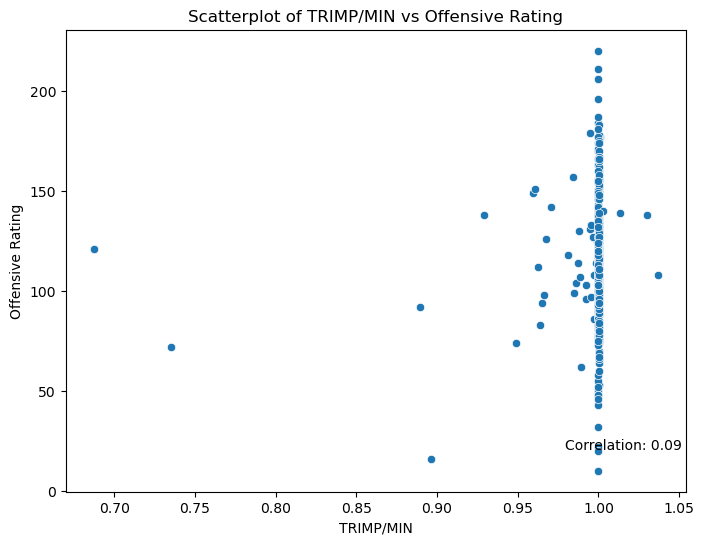

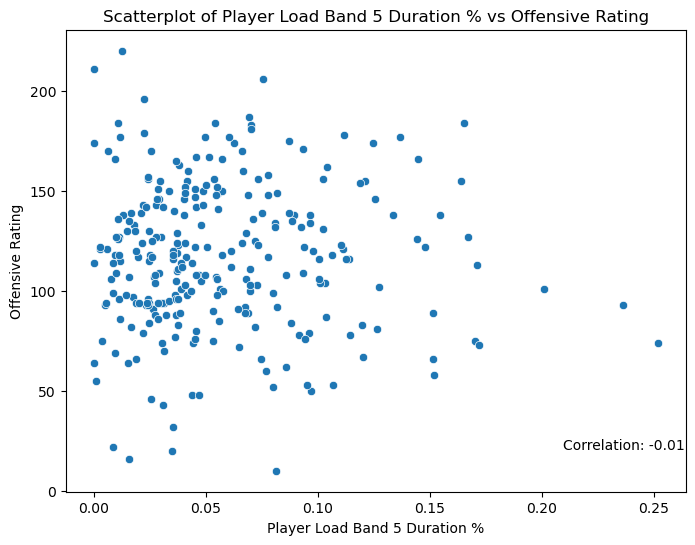

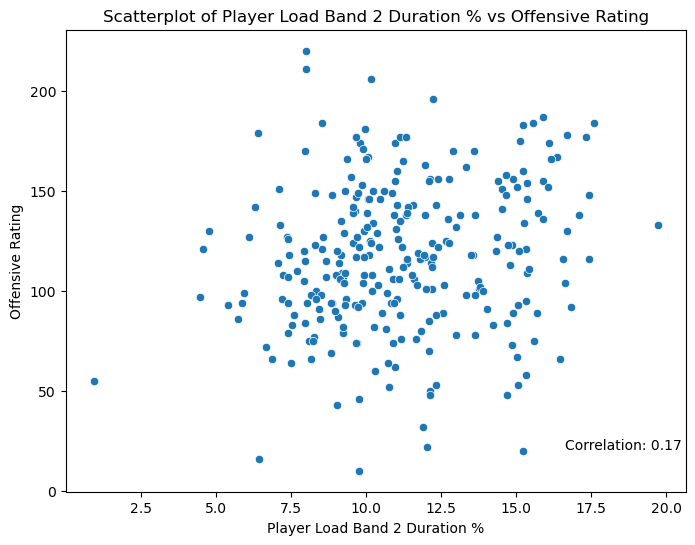

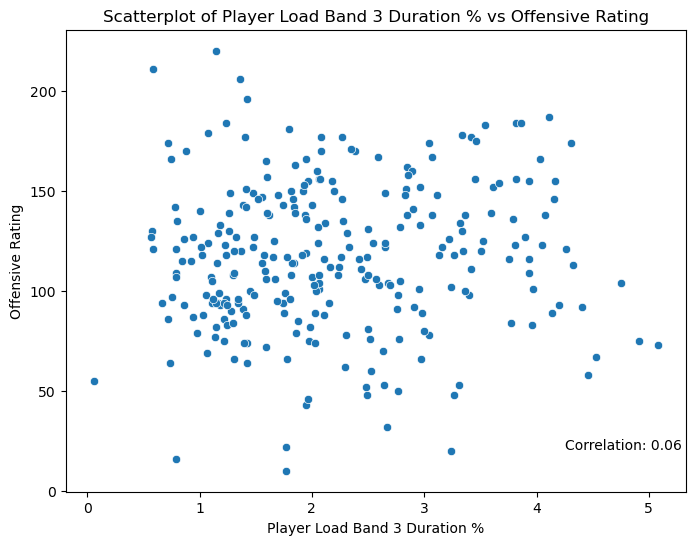

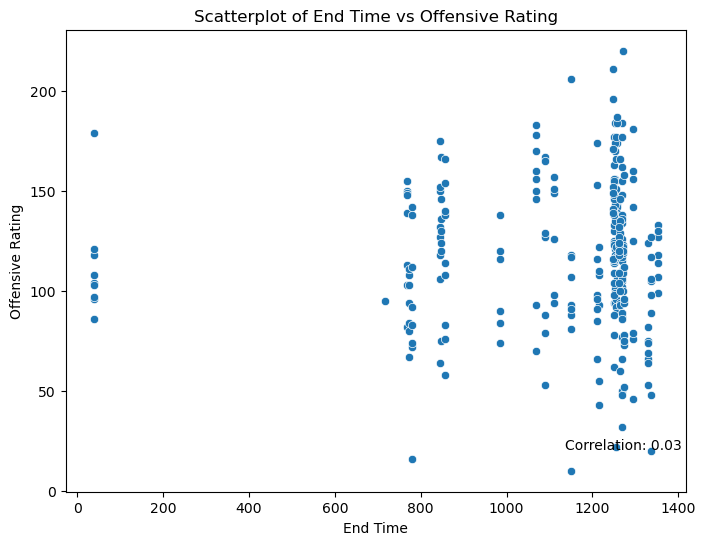

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

top_features = feature_importance.nlargest(10)

# Create a DataFrame with the selected top features
df_top_features = data[top_features.index]

# Plot scatterplots for each top feature against the target variable
for feature in top_features.index:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[feature], y=data['o_rtg'])
    
    # Calculate the correlation coefficient
    correlation_coefficient, _ = pearsonr(data[feature], data['o_rtg'])
    
    # Add correlation coefficient to the plot
    plt.text(0.9, 0.1, f'Correlation: {correlation_coefficient:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    
    plt.title(f'Scatterplot of {feature} vs Offensive Rating')
    plt.xlabel(feature)
    plt.ylabel('Offensive Rating')
    plt.show()
